# Classification Performance in Parkinson's Disease Case and Controls

## Introduction

This notebook will assess several different contemporary ML model to assess classification on predicting cases and controls between PD user and non-PD users. To ensure the most reliable classification performance, we have ensured that 
the data has been randomized properly (matched). 

Classification model will be assessed using several basic classification models like LogReg, RandomForest, Gradient Boosting (Sklearn), XGBoost. To address model reliability for future project, learning curve will be assessed to ernsure that model does not overfit. 


<b> Classification Steps: </b>

    1. Remove columns with more than 20% null entry
    
    2. Split data into training - holdout set (75-25)% ratio
    
    3. Impute Data using MICE Iterative Imputer 

    4. Recursive Feature Elimination to reduce overfitting 

    5. Grid Search the model hyperparameter with K-fold cross validation 
       to optimize desired prediction metrics (roc-auc)
    
    6. Assess best model on holdout set

    7. Assess Model Performance (metrics, learning curve) 

    8. Assess Feature Importances 

    9. Persist Best Model 

## Library Imports

In [1]:
# library and module imports for data retrieval and munging
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# some ML (scikit & xgboost) library imports for modelling
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import (train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve)
import sklearn.metrics as metrics
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, SGDClassifier)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

  warnings.warn(msg, category=DeprecationWarning)



## Retrieve Data

#### Global Variables

In [2]:
WALKING_GROUPED_FEATURES    = "syn21678699"
MATCHED_DEMOGRAPHICS        = "syn21614563"
ALL_DEMOGRAPHICS      = "syn21602828"
PREVIOUS_ASSAY_DEMOGRAPHICS = "syn8381056"

syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



### Helper Functions

#### a. Model Fitting Function

In [3]:
### helper functions ###
### functions used to reduce feature spaces and model fitting/training ###

def reduce_feature_rfecv(X, y, 
                 estimator, 
                 score_func):
    """
    function to reduce features by
    recursively eliminating and adding
    features and optimize based on the
    scoring metrics provided
    
    Args: X: independent variables 
          y: dependent variables
          score_func: metrics to optimze
    returns reduced dataframe
    """
    selector = RFECV(estimator, step=1, 
                     cv=10, 
                     scoring = score_func, 
                     n_jobs = -1)
    selector = selector.fit(X, y)
    return pd.DataFrame(data = selector.transform(X), 
             columns = X.columns[selector.support_])


def logreg_wrapper(X, y):
    """
    wrapper for logistic regression hyperparameter
    """
    model = LogisticRegression(random_state = 100)
    X = reduce_feature_rfecv(X, y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', model)
        ])
    param = [{'classifier__penalty': ['l1'],
             'classifier__C':[0.5, 0.7, 1],
             'classifier__solver':['liblinear'],
             'classifier__max_iter': [100, 300, 500],
             'classifier__multi_class': ['ovr']}]
    CV = GridSearchCV(estimator = pipe, param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}


def xgb_wrapper(X, y):
    """
    wrapper for logistic regression hyperparameter
    """
    model = XGBClassifier(random_state = 100)
    X = reduce_feature_rfecv(X,y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('classifier', model)
        ])
    param = {
        "classifier__learning_rate" : [0.01, 0.05, 0.1],
        "classifier__n_estimators"  : [10, 12, 15, 17],
        'classifier__max_depth'     : [2, 3, 4, 5],
        "classifier__subsample"     : [0.8, 0.9, 1],
        "classifier__reg_alpha"     : [0.1, 0.2, 0.3]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}
    

def gradientboost_wrapper(X, y):
    """
    wrapper for gradient boosting hyperparameter
    """
    model = GradientBoostingClassifier(random_state = 100)
    X = reduce_feature_rfecv(X,y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('classifier', model)
        ])
    param = {
        'classifier__max_depth'     : [2, 3, 4, 5],
        'classifier__learning_rate' : [0.01, 0.05, 0.1],
        "classifier__n_estimators"  : [10, 12, 15],
        "classifier__subsample"     : [0.8, 0.9, 1]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}


def randomforest_wrapper(X, y):
    """
    wrapper for random forest hyperparameter
    """
    model = RandomForestClassifier(random_state = 100)
    X = reduce_feature_rfecv(X,y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('classifier', model)
        ])
    param = {
        'classifier__n_estimators'  : [80, 90, 100],
        'classifier__min_samples_split':[2, 5, 10],
        'classifier__min_samples_leaf' : [1, 2, 4],
        'classifier__max_depth': [2, 4, 6]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", n_jobs = -1, cv = 10, 
                      verbose = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}

#### b. Model Results & Visualization Function

In [4]:
### function to showcase results and metrics of predictive model ###
def get_results_dataframe(X_train, y_train, 
                          X_test, y_test, 
                          *fitted_models):
    data_dict = {}
    data_dict["model"] = []
    data_dict["parameter"] = []
    data_dict["roc-auc-cv"] = []
    data_dict["roc-auc-test"] = []
    data_dict["log-loss-test"] = []
    data_dict["f1-score-test"] = []
    for fitted_model in fitted_models:
        if isinstance(fitted_model, dict):
            model = fitted_model["model"]
            features = fitted_model["features"]
        else:
            model    = fitted_model
            features = X_test.columns 
        try:
            data_dict["model"].append(type(model.best_estimator_["classifier"]).__name__)
            data_dict["parameter"].append(model.best_params_)
            data_dict["roc-auc-cv"].append(model.best_score_)
        except:
            data_dict["model"].append(type(model).__name__)
            data_dict["parameter"].append(np.NaN)
            data_dict["roc-auc-cv"].append(np.mean(cross_val_score(model, X_train, 
                                                           y_train, scoring = "roc_auc")))
        y_true, y_pred = y_test, model.predict(X_test[features])
        data_dict["roc-auc-test"].append(metrics.roc_auc_score(y_true, y_pred))
        data_dict["log-loss-test"].append(metrics.log_loss(y_true, y_pred))
        data_dict["f1-score-test"].append(metrics.f1_score(y_true, y_pred))
    data = pd.DataFrame(data_dict)
    return data


def visualize_feature_importances(X, *fitted_models):
    for fitted_model in fitted_models:
        try:
            features = fitted_model.best_estimator_["classifier"].feature_importances_
        except:
            features = fitted_model.best_estimator_["classifier"].coef_[0]

        series = np.abs(pd.Series(data = features, 
                            index = X.columns))\
                            .sort_values(ascending = True).tail(5)
        plt.figure(figsize = (8,5))
        plt.title("Feature Importances based base on %s"%type(fitted_model.best_estimator_["classifier"]).__name__)
        series.plot(kind = "barh")
        plt.show()
        

def plot_roc_auc_curve(X_test, y_test, *fitted_models):
    for fitted_model in fitted_models:
        model_name = type(fitted_model.best_estimator_["classifier"]).__name__
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        y_pred = fitted_model.predict_proba(X_test)
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[1], tpr[1], linestyle='-', 
                 label='%s ROC curve (area = %0.2f)' % 
                 (model_name, roc_auc[1]))
    
    

def plot_learning_curves(X_train, y_train, *fitted_models):
    for fitted_model in fitted_models:
        try:
            estimator = fitted_model.best_estimator_
            model_name = type(fitted_model.best_estimator_["classifier"]).__name__
        except:
            estimator = fitted_model
            model_name = type(fitted_model).__name__
        train_sizes, train_scores, valid_scores = learning_curve(estimator, 
                                                                X_train, y_train, 
                                                                scoring = "roc_auc", 
                                                                cv = 10, random_state = 100, 
                                                                train_sizes = np.linspace(0.1, 1, 10))
        pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1), 
                             "valid_scores": np.mean(valid_scores, axis = 1)}, 
                     index = train_sizes)\
                    .plot(figsize = (8,5), linestyle='-', marker = 'o')
        plt.ylabel("roc-auc")
        plt.title("%s Learning Curve"%model_name)
        plt.xlabel("Training Size")
        plt.show()
        

def plot_rfecv_performance(X_train, y_train, *fitted_models):
    plt.figure(figsize = (12,8))
    for fitted_model in fitted_models:
        selector = RFECV(fitted_model, 
                         step=1, 
                         cv=10, 
                         scoring = "roc_auc", 
                         n_jobs = -1)
        selector = selector.fit(X_train_impute, y_train)
        # Plot number of features VS. cross-validation scores
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation AUC-ROC score")
        plt.plot(range(1, len(selector.grid_scores_) + 1), 
                 selector.grid_scores_, 
                 label = type(fitted_model).__name__)
    plt.title("AUC-ROC Score Based on RFECV (10-fold)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

#### Preliminary Cleanups
This is a preliminary cleanup on data, essentially changing column names and choosing columns that is required

In [5]:
#### get data ####
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES )
demographic = query.get_file_entity(syn, MATCHED_DEMOGRAPHICS).reset_index()


### filter unused columns ###
data = data[[feat for feat in data.columns 
            if ("window" not in feat) 
            and ("steps" not in feat) 
            and ("avg_number_of_strides" not in feat) 
            and ("amax" not in feat)
            and ("x_speed_of_gait" not in feat)
            and ("y_speed_of_gait" not in feat)
            and ("z_speed_of_gait" not in feat)]]


#### filter datasets ####
data = data[(data["test_type"] == "walking") & 
            (data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE") &
            (data["class"] != "MS")]

#### merge inner ####
data = pd.merge(
    demographic[["healthCode"]], data, on = "healthCode", how = "inner")

data = data.set_index("healthCode")


#### clean sparse feature ####
data = data[data.columns[data.isnull().mean() < 0.2]]


#### cols of choice ####
metadata_cols = ["test_type", "phoneInfo", "age", 
                 "gender", "table_version", 
                 "nrecords", "class"]
feat_cols = [feat for feat in data.columns if (feat not in metadata_cols)]

### 1. Impute missing data on training using MICE Model (Iterative Imputer)

In this data model, I will be imputing missing values using the MICE imputer. Essentially, by using MICE imputer, we will be using regression (repeatedly) to fit null values by using other known data. MICE iterative imputer is chosen due to the assumption that the missing values might be a MAR (missing at random) where the users might or might not showcased a certain gait signal because of random occurence e.g. null in rotation speed is just a random occurence that the user are not doing any rotation; MICE imputer is also a good generalization model that does not assume disassociation between one column to another, meaning that it will not cause as much bias as towards simply imputing by mean or median.

<b> This imputer is still a generalized model and might be subject to future improvement. </b>

In [6]:
### map target variable ###
train = data[feat_cols]
target = data["class"].map({"PD":1, "control":0})

### split train test split ###
X_train, X_test, y_train, y_test = train_test_split(
    train, target,                                          
    test_size = 0.25,                                
    random_state = 100)

### imputer object ###
imputer = IterativeImputer(
    missing_values = np.nan,
    random_state = 100,
    initial_strategy = "median")\
    .fit(X_train)

### impute base on training sets ###
X_train_impute = pd.DataFrame(
    imputer.fit_transform(X_train), 
    columns = X_train.columns)

### impute fit on training predict on test ###
X_test_impute = pd.DataFrame(
    imputer.fit_transform(X_test), 
    columns = X_train.columns)

### 2. Assessing Initial Model Performance

Before we do any optimization on any of the ML model, we would like to have a baseline model based on the features that we currently have. Thus, we will test the baseline model by simply fit/predict on the training and test sets of our feature data, see what the initial performances <b> (roc-auc, f1-score, log-loss) </b> look like, and try to iterate/improve the baseline model. We will also be assessing the learning curve of our initial model and see whether the initial model can pick up some signals from the feature data. 

#### a. Initial Model Fitting

In [7]:
init_lr_model = LogisticRegression(random_state = 100)\
                .fit(X_train_impute, y_train)

init_rf_model = RandomForestClassifier(
                random_state = 100, 
                n_estimators = 100,
                max_depth = 2,
                bootstrap = True)\
                .fit(X_train_impute, y_train)

init_gb_model = GradientBoostingClassifier(
                random_state = 100, 
                n_estimators = 20,
                subsample = 0.8,
                max_depth = 2)\
                .fit(X_train_impute, y_train)

init_xgb_model = XGBClassifier(
                random_state = 100, 
                n_estimators = 20,
                reg_alpha = 0.1,
                max_depth = 2)\
                .fit(X_train_impute, y_train)

init_MLP_model = MLPClassifier().fit(X_train_impute, y_train)
init_KNN_model = KNeighborsClassifier().fit(X_train_impute, y_train)

#### b. Initial Model Metrics Performance

In [8]:
get_results_dataframe(
    X_train_impute, y_train,
    X_test_impute, y_test, 
    init_xgb_model,
    init_lr_model,
    init_gb_model,
    init_rf_model,
    init_KNN_model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,XGBClassifier,NaN,0.632630,0.615751,13.262262,0.594752
1,LogisticRegression,NaN,0.609046,0.618926,13.166879,0.627027
2,GradientBoostingClassifier,NaN,0.614395,0.582753,14.407218,0.572238
3,RandomForestClassifier,NaN,0.617382,0.607662,13.548512,0.601124
4,KNeighborsClassifier,NaN,0.563054,0.552839,15.456785,0.578125


#### c. Learning Curve

We will try to fit visualize learning curves on the top 4 model (sklearn-GB, XGB, LogReg, RF) and see whether the model is able to learn from our dataset. 

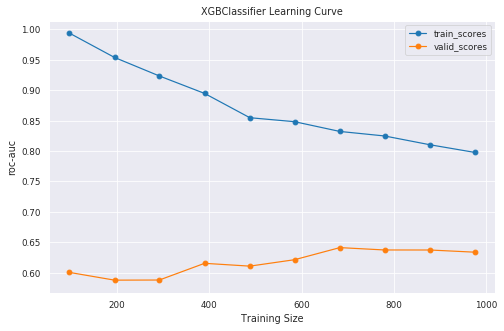

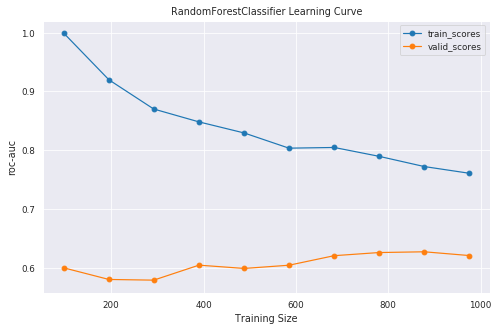

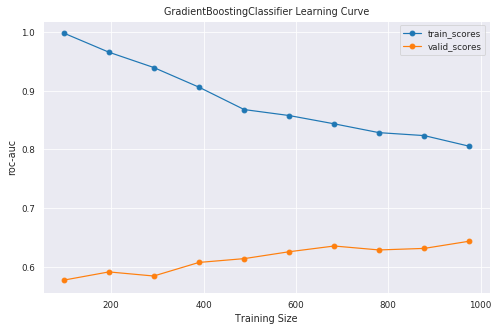

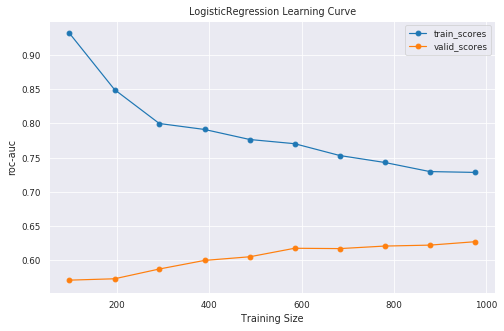

In [9]:
plot_learning_curves(
    X_train_impute, 
    y_train, 
    init_xgb_model,
    init_rf_model,
    init_gb_model,
    init_lr_model)

#### Learning Curve Diagnostics on Initial Model

Looking from the learning curve above, we can see that there is still a significant gap between the learning curve of the training scores and the validation scores. An ideal model that is desired is where the training scores and validation scores converges together, which indicates reliability when we do deploy our model into production. In terms of performance some parameter can still be tuned to see whether we can at least improve our AUC closer to 0.7. 

Our initial model learning curves indicates that using trees with depth around 3-4 and using low amount of estimators will help us generalize our model better in production. Thus we will try to tune the parameters and see whether if we can get a significant improvement to the model. 

#### d. Visualizing Feature Elimination

An approach of feature elimination can be done recursively, by adding and eliminating feature combinations repeatedly. This process is more effective than manually eliminating the features but it will be a time-consuming process as the data scales up. However, as we have large number of features but not as much samples on the dataset, this feature will be advantageous as we will not require that much time in repeatedly fitting the model with different subset of features. 

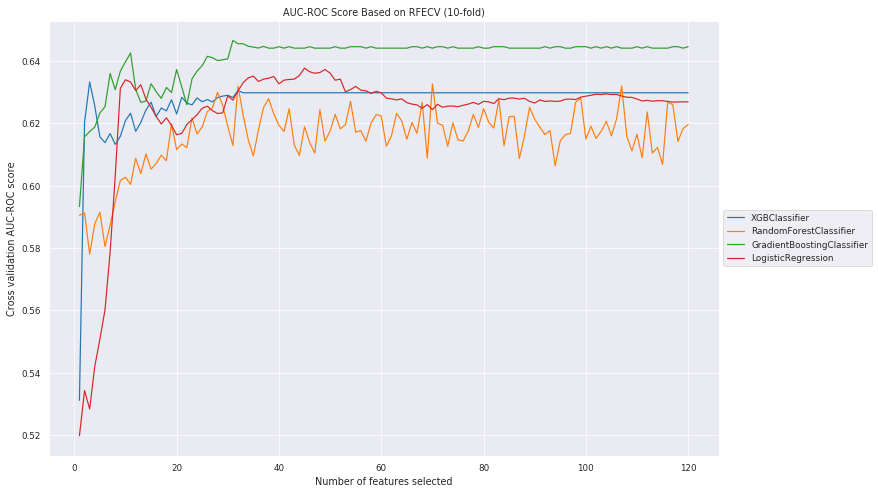

In [10]:
plot_rfecv_performance(
    X_train_impute, 
    y_train, 
    init_xgb_model,
    init_rf_model,
    init_gb_model,
    init_lr_model)

Looking from the features usage above, we can see that we do not necessarily require 140 features to reach the optimal result of our model. However, due to the high feature dimensionality, as well as features that are heavily correlated to each other, an optimal feature set can be attained through having only small sample of the feature. 

## 3. Optimizing ML Model Performance

#### a. Slightly Optimization Approach 

To optimize the model, we know from above that our model does not entirely require the entire data to hit the optimal performance, thus, we would like to optimize the model by reducing its feature space. Hyperparameter can also help our model fit better, however, it could make the model more susceptible to overfitting, thus we might not want to optimize with too many iterations.

- 10 fold cv hyperparameter tuning
- Stratified K-Fold is used to sustain distribution of controls and cases on each fold
- Tree max depth will all be less than 10 to reduce overfitting
- Number of estimators will be kept low
- During optimization regularization parameter will be added and subsampling of data to generalize the model better

<b> * CV optimization process will be run on an 16-core AWS instance, so it might be computationally expensive </b>

In [11]:
 ## models ##
cv_lr_model = logreg_wrapper(X_train_impute, y_train)
cv_rf_model = randomforest_wrapper(X_train_impute, y_train)
cv_gb_model = gradientboost_wrapper(X_train_impute, y_train)
cv_xgb_model = xgb_wrapper(X_train_impute, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.0s finished


Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   29.0s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 692 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    7.8s finished


Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 2340 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 3440 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:   24.0s finished


#### b. Prediction Results

In [12]:
results = get_results_dataframe(X_train, y_train,
                      X_test_impute, 
                      y_test, 
                      cv_gb_model,
                      cv_rf_model,
                      cv_lr_model,
                      cv_xgb_model)

In [13]:
results

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.685587,0.607387,13.548492,0.579882
1,RandomForestClassifier,"{'classifier__max_depth': 6, 'classifier__min_...",0.652838,0.615720,13.262259,0.592375
2,LogisticRegression,"{'classifier__C': 0.5, 'classifier__max_iter':...",0.662474,0.624420,12.976053,0.630435
3,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.687423,0.601984,13.739325,0.583815


The ML prediction shows that the optimized model have better cross validation score, scoring above 0.65 in general. 

#### c. Performance Stability

On assessing which model is the most reliable, we would like to test its performance stability based on the cross validation performance best parameter in terms of AUC. 

In [14]:
model_dict = {}
for cv_model in [cv_gb_model, cv_xgb_model, cv_rf_model, cv_lr_model]:
    cv_model = cv_model["model"]
    cv_model_name = type(cv_model.best_estimator_["classifier"]).__name__
    best_index = cv_model.best_index_
    model_dict[cv_model_name] = []
    for key in cv_model.cv_results_.keys():
        if ("split" in key) and ("test_score" in key):
            val = cv_model.cv_results_[key][best_index]
            model_dict[cv_model_name].append(val)

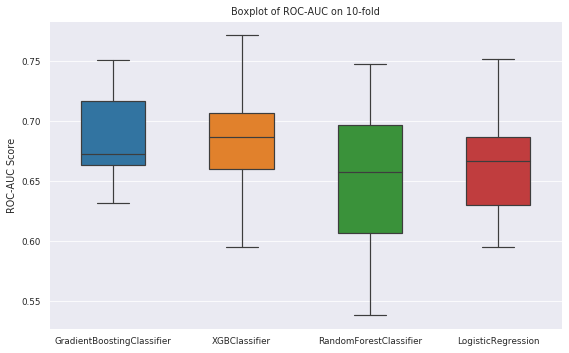

In [15]:
model_performance_data = pd.DataFrame(model_dict)

plt.figure(figsize = (8, 5))
sns.boxplot(data = model_performance_data, 
            width = 0.5)
plt.title("Boxplot of ROC-AUC on 10-fold")
plt.ylabel("ROC-AUC Score")
plt.tight_layout()
plt.show()

In terms of stability, it can be said that random forest is the most fluctuative, by looking at its box plot with high deviation, whereas XGBoost is the most consistent, and can score as high as more than 0.7 on its 75th quantiles. However, in addressing which model is the most consistemt, choosing Logistic Regression might be the most usable due to its capability to generalize data the best. This is consistent to how simple models are actually better in smaller samnple sizes, as our data grows, then we might be able to take more data samples and implement more complicated models.

#### d. Feature Importances

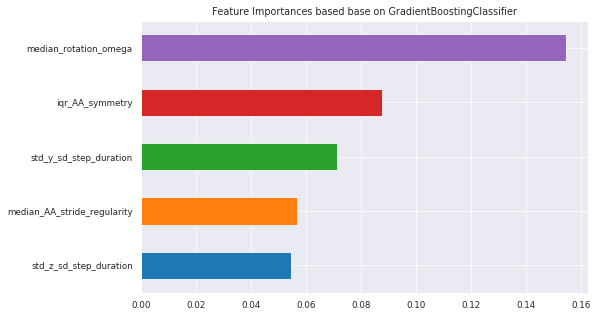

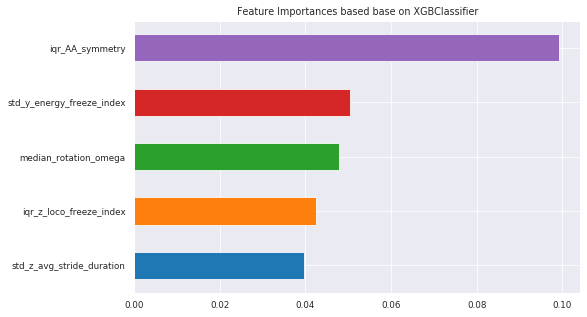

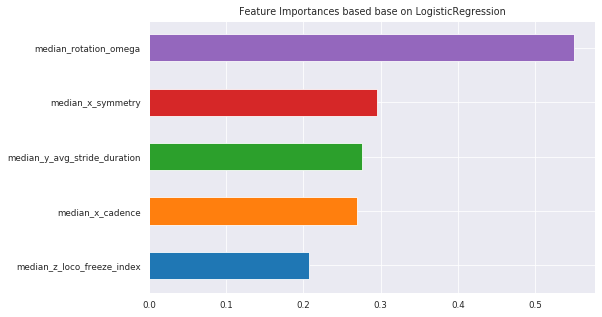

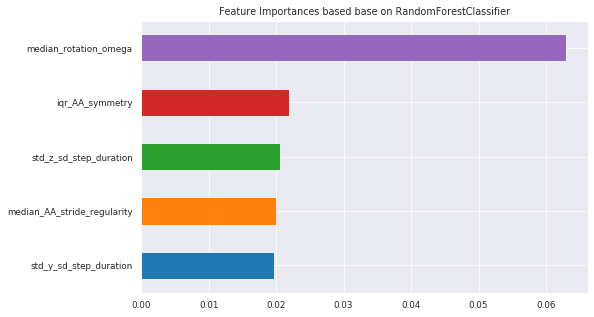

In [16]:
for fitted_model in [cv_gb_model, cv_xgb_model, cv_lr_model, cv_rf_model]:
    visualize_feature_importances(X_train_impute[fitted_model["features"]], 
                                  fitted_model["model"])

Based on the models fitted by cross validation, we can see that median of rotation speed is a prominent feature in classifying PD case vs controls. This is consistent to which in real life where PD has a hard time turning/rotating whenever they are walking. However, as we are using 10-fold cross validation, the strongest feature might be slightly overfitted as we fit the training data several times when assessing different folds. 

#### e. ROC-AUC Curve

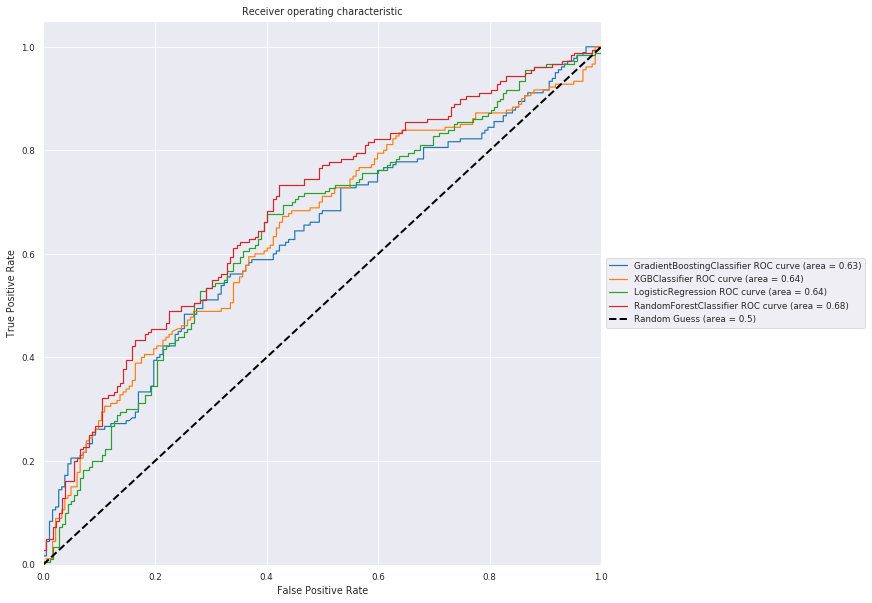

In [17]:
plt.figure(figsize = (10,10))


for fitted_model in [cv_gb_model, cv_xgb_model, cv_lr_model, cv_rf_model]:
    plot_roc_auc_curve(X_test_impute[fitted_model["features"]], 
                       y_test, 
                       fitted_model["model"])

plt.plot([0, 1], [0, 1], color='black', 
             lw=2, linestyle='--', 
             label = "Random Guess (area = 0.5)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### e. Learning Curve (Train - 10 fold cross validation set)

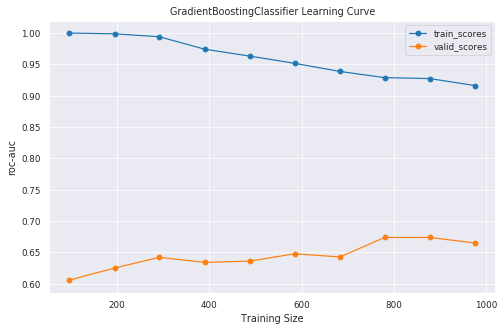

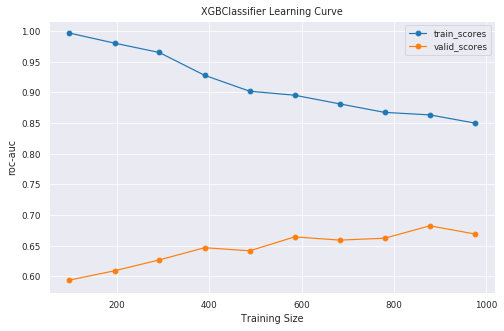

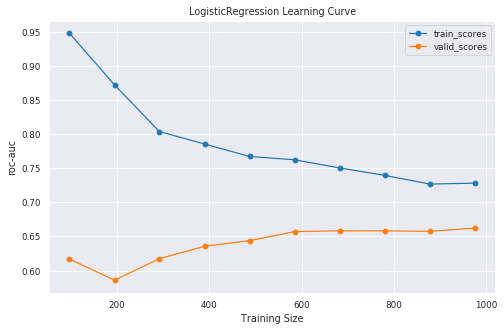

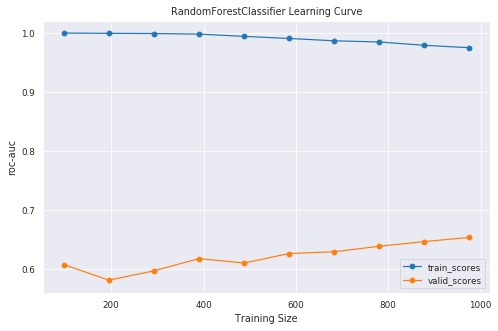

In [18]:
for fitted_model in [cv_gb_model, cv_xgb_model, cv_lr_model, cv_rf_model]:
    plot_learning_curves(X_train_impute[fitted_model["features"]], 
                         y_train, 
                         fitted_model["model"])

### Results:


The assessment above shows that the optimized model are able to score above >0.65 AUC-ROC, which means that our model is quite able to pick up some signals from our feature data. However, looking from the learning curves, despite our best effort in reducing variance between the training and cross-validation scores through feature reduction, it seems that it could only improve by a small margin. Most of the model score higher, or as much as the performance we had on mHealthTools (previous study on gait), with lower training time and smaller feature sets. 

<b> Logistic Regression </b> (so-far) might be a reasonable model in deployment due to its capability to generalize the features due to how the learning curve is able to least overfit due to the difference between the training scores and the validation scores getting closer to each other on each data iteration, which is only apparent in XGBoost. 

However, this is still an MVP of a predictive performance analysis where we would iterate the model further as we go with more data from the Gait database from the MPower.